# Multi-Omics Analysis for CRC Survival Prediction

Bla



## Imports and helper functions

In [1]:
import os
import random
import functools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import lifelines
from tqdm.notebook import tqdm, trange

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold

In [2]:
from coxae.baselines.pca import PCAClustering
from coxae.datasets import download_maui_data
from coxae.preprocessing import maui_scale
from coxae.utils import get_kmfs

In [3]:
# Set the random seeds
seed = 0
np.random.seed(seed)
random.seed(seed)

In [4]:
dim_reduction = TSNE
dim_reduction_label = "TSNE_{}"

### Data visualisation

In [5]:
def get_histograms_from_columns(
        df, columns_to_plot,
        sharex=False, sharey=False, figsize_per_plot=5,
        bins=50, stat="density", kde=True
        ):
    plot_number = len(columns_to_plot)
    rows = max(1,int(plot_number**0.5))
    cols = max(1,int(not plot_number%rows==0) + plot_number//rows)
    fig, axs = plt.subplots(
            rows, cols, sharex=sharex, sharey=sharey, squeeze=False,
            figsize=(figsize_per_plot*cols,figsize_per_plot*rows))
    color_palette = sns.husl_palette(plot_number)
    for i, column in zip(range(plot_number),columns_to_plot):
        row = i%rows
        col = i//rows
        sns.histplot(df[column], bins=bins, stat=stat, kde=kde, label=column, ax=axs[row,col], color=color_palette[i])
    return fig, axs

## Data Acquisition and Pre-Processing

### Acquiring data from the MAUI's paper study

In [6]:
data_directory = "./data/maui_data"

In [7]:
download_maui_data(data_directory)

In [8]:
survival = pd.read_csv(os.path.join(data_directory, 'survival.csv'), index_col=0)
survival.head()

,duration,observed,gender,age,stage
bcr_patient_barcode,,,,,
TCGA-3L-AA1B,154,False,0,61.312329,1.0
TCGA-4N-A93T,8,False,1,67.186301,3.0
TCGA-4T-AA8H,160,False,0,42.449315,2.0
TCGA-5M-AAT4,49,True,1,74.232877,4.0
TCGA-5M-AAT6,290,True,0,40.690411,4.0


In [9]:
subtypes = pd.read_csv(os.path.join(data_directory, 'subtypes.csv'), index_col=0)
subtypes.head()

,dataset,age,gender,stage,pt,pn,pm,tnm,grade,msi,cimp,kras_mut,braf_mut,cms_label,osMo,osStat,rfsMo,rfsStat
sample,,,,,,,,,,,,,,,,,,
TCGA-A6-2670,tcga,45.0,male,2.0,3.0,0.0,0.0,IIA,NaN,NaN,CIMP.Neg,0.0,0.0,CMS4,13.906849,0.0,NaN,NaN
TCGA-A6-2671,tcga,85.0,male,4.0,3.0,2.0,1.0,IV,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,21.304110,0.0,NaN,NaN
TCGA-A6-2672,tcga,82.0,female,3.0,3.0,1.0,0.0,IIIB,NaN,msi,CIMP.High,0.0,0.0,CMS1,16.536986,0.0,NaN,NaN
TCGA-A6-2674,tcga,71.0,male,4.0,3.0,2.0,1.0,IV,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,17.194521,0.0,NaN,NaN
TCGA-A6-2675,tcga,78.0,male,2.0,3.0,0.0,NaN,IIA,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,16.931507,0.0,NaN,NaN


Plot a Kaplan-Meier plot of the whole dataset to have better view of it

<AxesSubplot:xlabel='timeline'>

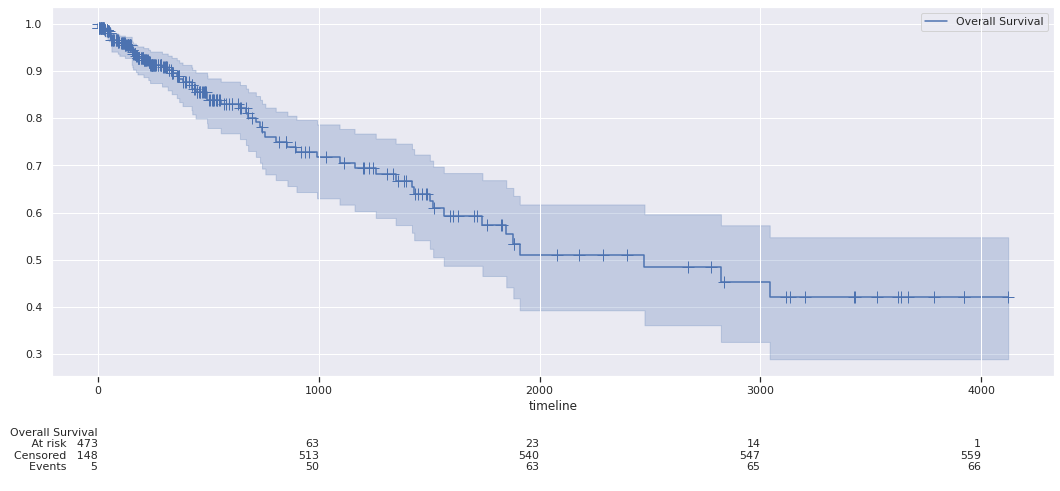

In [10]:
kmf = lifelines.KaplanMeierFitter(label="Overall Survival")
kmf.fit(durations=survival["duration"],
        event_observed=survival["observed"])
plt.figure(figsize=(15,7))
kmf.plot(show_censors=1, ci_show=1, at_risk_counts=True)

Read the cBioPortal dataset's mRNA (Seq V2), Linear CNA and Methylation (hm450) datasets.

In [11]:
cnv = pd.read_csv(os.path.join(data_directory, 'cnv.csv'), index_col=0)
gex = pd.read_csv(os.path.join(data_directory, 'gex.csv'), index_col=0)
mut = pd.read_csv(os.path.join(data_directory, 'mut.csv'), index_col=0)


cnv.shape[0], gex.shape[0], mut.shape[0]

(100, 1000, 200)

Check the maximum RNAseq count value in the dataset.

In [12]:
gex.max().max()

123568.560354

In [13]:
gex_tcga = maui_scale(gex.loc[:,gex.columns.str.contains('TCGA')])
gex_ccle = maui_scale(gex.loc[:,~gex.columns.str.contains('TCGA')])

gex = pd.concat([gex_tcga, gex_ccle], axis=1)
gex = maui_scale(gex)
gex.head()

,TCGA-DM-A1D0,TCGA-4T-AA8H,TCGA-G4-6322,TCGA-AA-A02E,TCGA-CA-5797,TCGA-G4-6317,TCGA-DM-A28C,TCGA-A6-2679,TCGA-AG-3732,TCGA-A6-2685,...,SNU1033_LARGE_INTESTINE,SNU175_LARGE_INTESTINE,SNU503_LARGE_INTESTINE,SW1116_LARGE_INTESTINE,HCC56_LARGE_INTESTINE,SW403_LARGE_INTESTINE,SW837_LARGE_INTESTINE,NCIH716_LARGE_INTESTINE,HT55_LARGE_INTESTINE,RKO_LARGE_INTESTINE
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000202198,-0.089120,-0.088563,-0.088906,-0.089667,-0.088973,-0.083947,-0.089080,-0.088551,-0.089372,-0.087775,...,-0.533138,2.542210,-0.787012,-0.609028,-0.330970,0.156823,0.344240,0.053214,0.763240,1.470719
ENSG00000211895,-0.523424,-0.202332,0.570615,-0.413167,-0.397846,-0.507563,-0.478897,12.480840,0.453555,0.285514,...,-0.491682,-0.512073,-0.376185,1.310930,-0.512073,-0.117894,-0.380050,-0.487817,-0.351135,-0.512073
ENSG00000034510,-0.033693,-0.404153,-0.453233,-0.099766,-0.244176,0.139135,-0.637896,1.407156,-1.066801,0.485294,...,-0.258449,-0.229124,-0.663397,-0.916127,0.670186,-0.638025,-1.157067,-0.657820,0.137436,-0.475331
ENSG00000087086,8.178617,-1.318908,-0.841834,-0.396125,0.277463,-0.438901,-0.522082,-0.993424,-1.322327,0.556441,...,-0.653667,-1.081281,4.123571,-0.800612,-0.409376,-0.445570,0.136440,0.135698,1.448641,2.778090
ENSG00000102837,-0.511785,-0.490640,-0.159594,-0.284401,-0.433786,-0.518334,2.243403,-0.400271,-0.453776,-0.463837,...,-0.158675,-0.161104,-0.161094,-0.161145,7.250145,-0.148832,-0.161213,-0.161194,-0.159373,-0.161196


Get the datasets that will be used as features:

In [14]:
clinical_patients = set(survival.index)
gex_patients = set(gex.T.index)
cnv_patients = set(cnv.T.index)
mut_patients = set(mut.T.index)

all_sets = [clinical_patients, gex_patients, cnv_patients, mut_patients]
all_patients = functools.reduce(lambda x, y: x|y, all_sets, set())
patients_on_all_datasets = functools.reduce(lambda x, y: x&y, all_sets, all_patients)

In [15]:
df_clin = survival.loc[patients_on_all_datasets]
df_gex = gex.T.loc[patients_on_all_datasets]
df_cnv = cnv.T.loc[patients_on_all_datasets]
df_mut = mut.T.loc[patients_on_all_datasets]
feature_dfs = [df_gex, df_cnv, df_mut]

In [16]:
set(df_cnv.columns) & set(df_mut.columns)

{'PTPRT'}

In [17]:
df_cnv.columns = map(lambda x: x+"_cnv", df_cnv)

In [18]:
set(df_cnv.columns) & set(df_mut.columns)

set()

Get the input dataset:

In [19]:
df_ae = functools.reduce(lambda x,y: x.join(y), feature_dfs[1:], feature_dfs[0])
X = scale(df_ae)
X = df_ae.values
durations = df_clin["duration"].values
events = df_clin["observed"].values

Plot a reduced dimensionality view of the dataset:

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


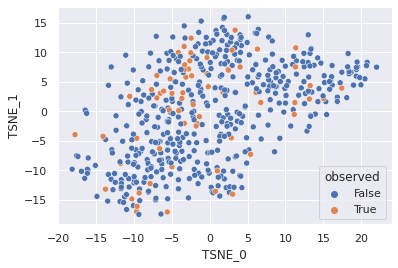

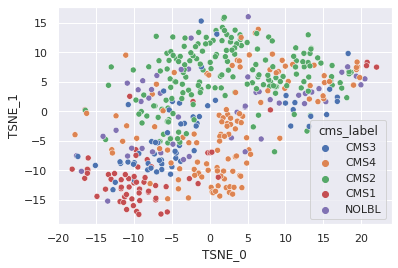

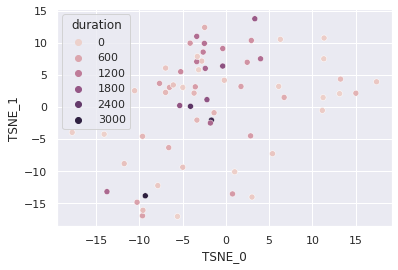

,TSNE_0,TSNE_1,duration,observed,gender,age,stage,cms_label
TCGA-AG-A015,11.018049,0.256791,0,False,0,64.372603,1.0,CMS3
TCGA-D5-5538,-2.802427,-14.695986,204,False,0,60.202740,3.0,CMS4
TCGA-D5-6533,-0.456969,12.510969,40,False,0,68.413699,3.0,CMS2
TCGA-CA-5796,-7.298957,-7.248023,12,False,0,53.021918,2.0,CMS3
TCGA-DM-A1D7,-3.146417,5.776858,0,True,1,82.580822,2.0,CMS2
...,...,...,...,...,...,...,...,...
TCGA-F4-6808,1.953583,13.677771,14,False,0,54.254795,1.0,CMS2
TCGA-G5-6572,4.013495,7.495184,1432,True,1,56.095890,0.0,CMS4
TCGA-NH-A6GB,-3.359220,14.446787,170,False,0,71.506849,3.0,NaN
TCGA-G4-6298,-3.533545,3.122891,715,True,1,90.063014,3.0,CMS2


In [20]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(X), index=df_ae.index, columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin).join(subtypes[["cms_label"]], how="left")
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="observed")
plt.show()
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="cms_label")
plt.show()
sns.scatterplot(data=df_plot[df_plot["observed"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="duration")
plt.show()
df_plot

## Train the model

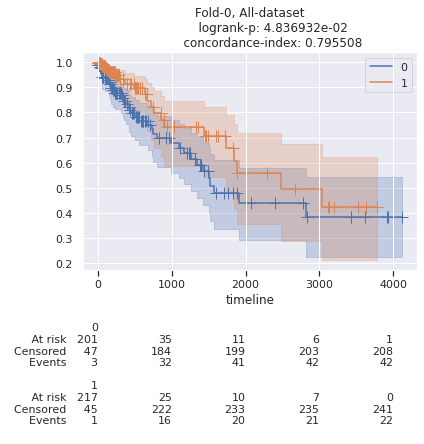

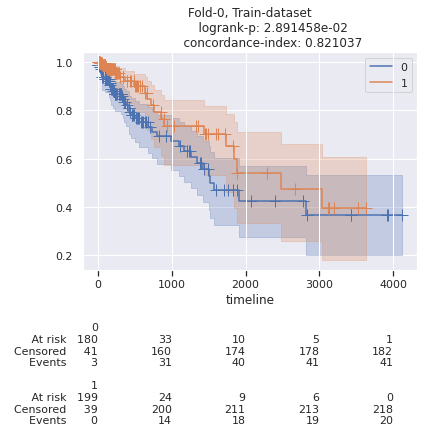

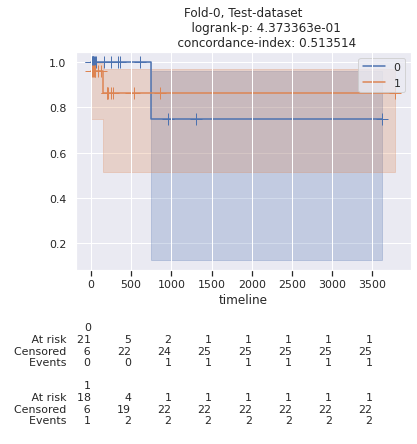

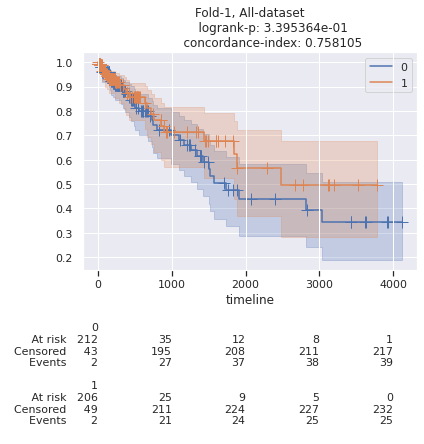

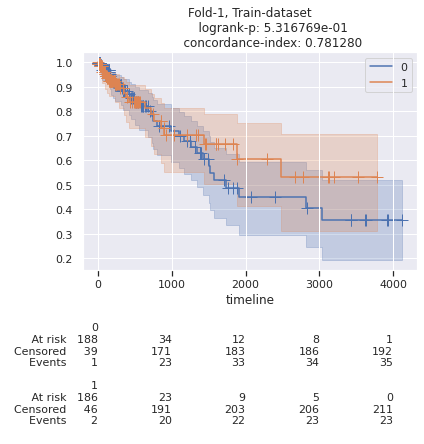

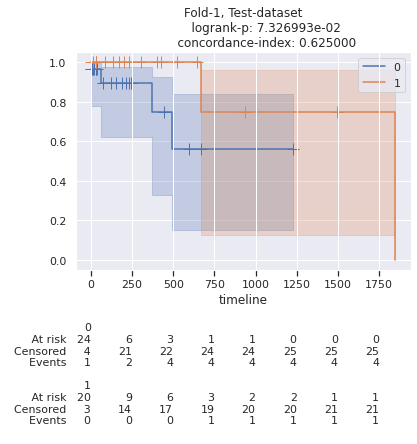

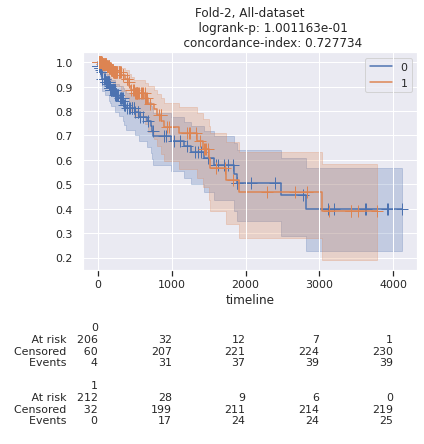

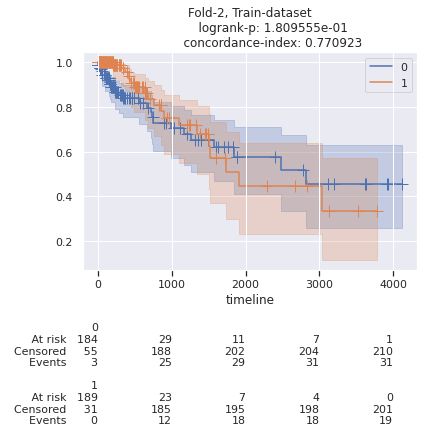

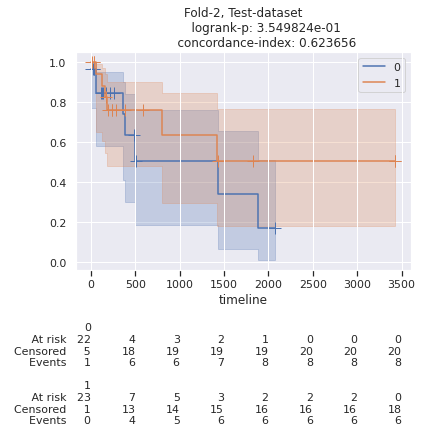

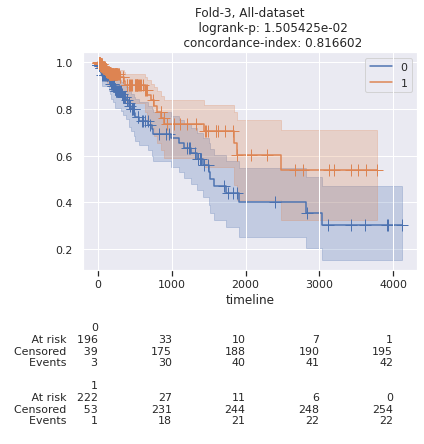

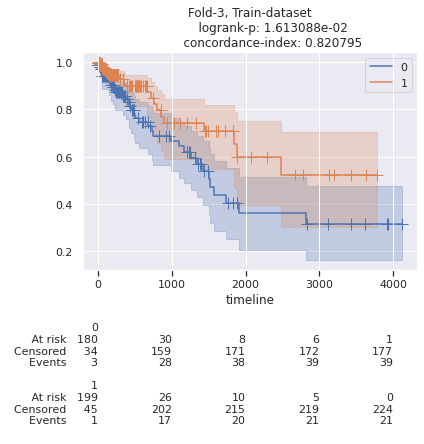

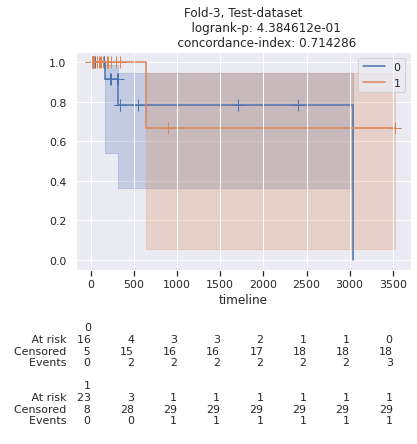

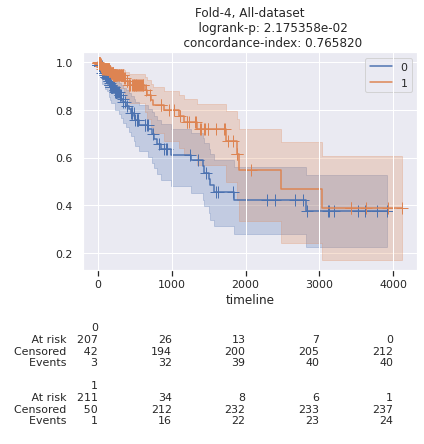

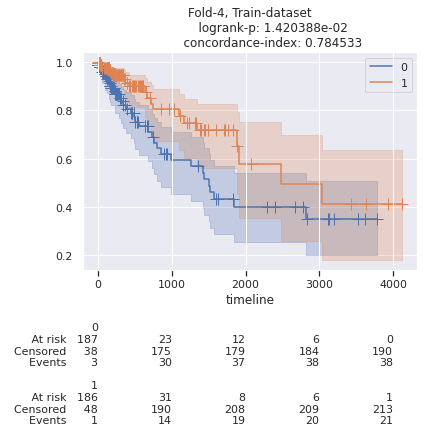

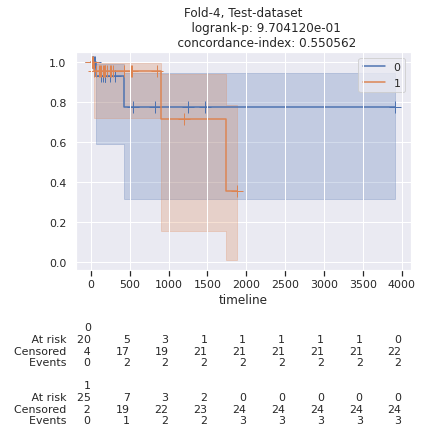

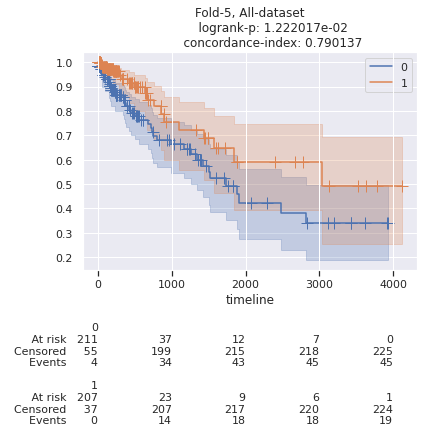

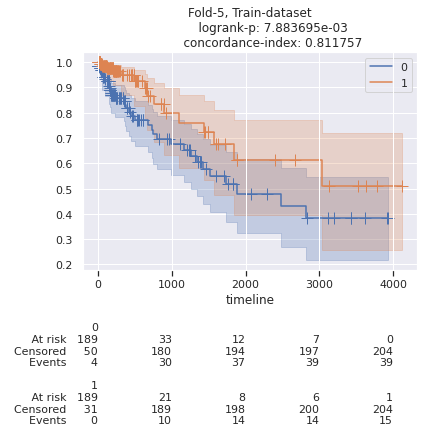

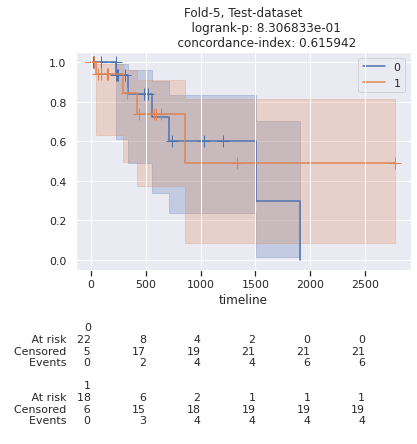

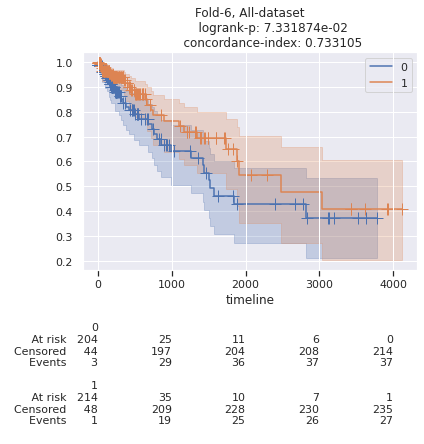

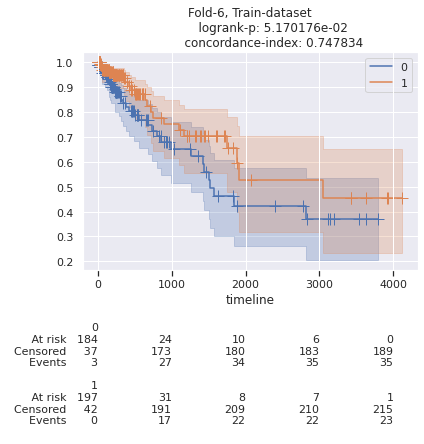

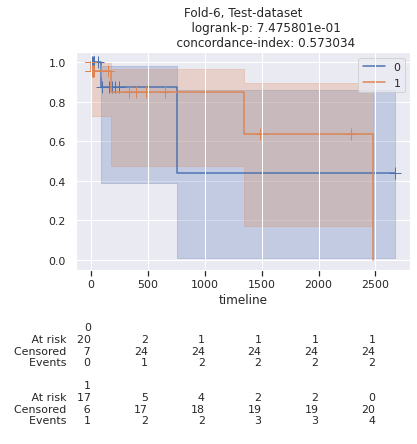

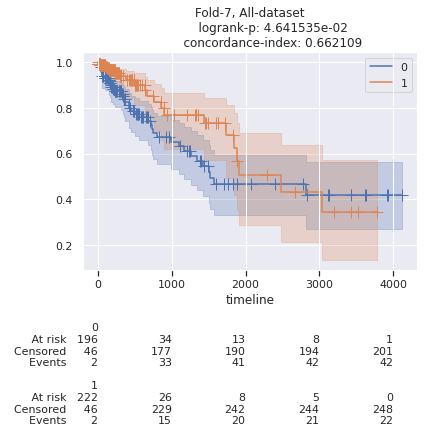

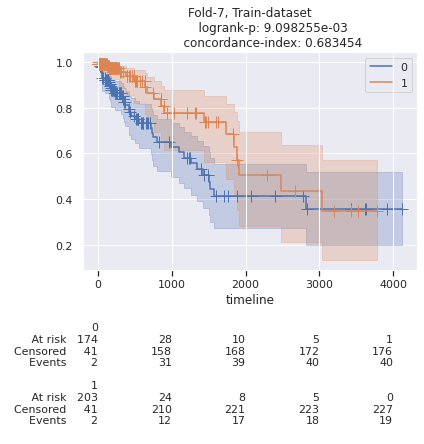

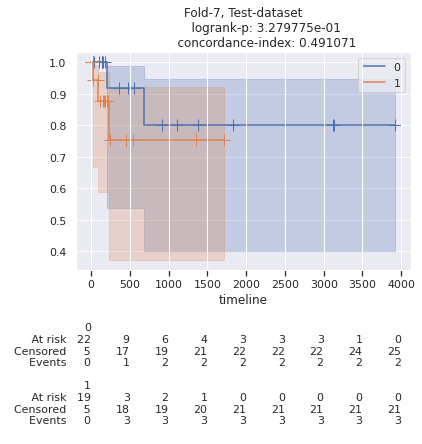

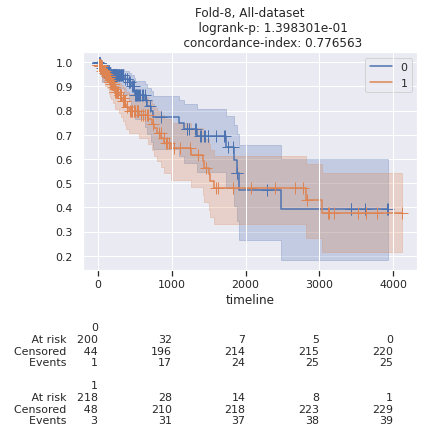

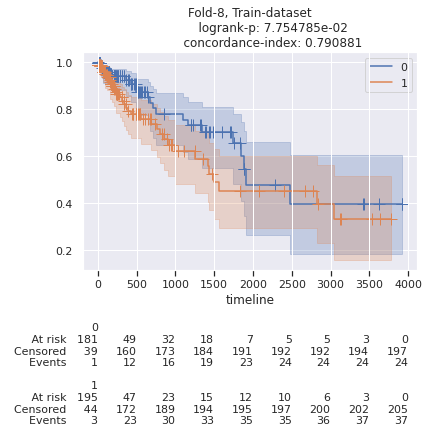

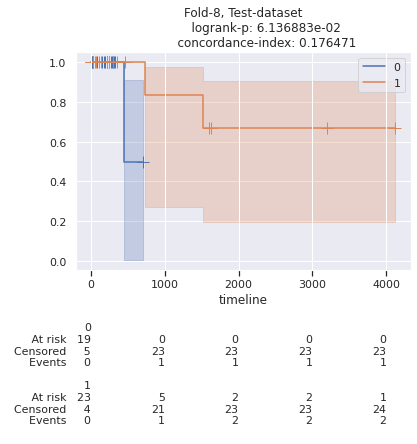

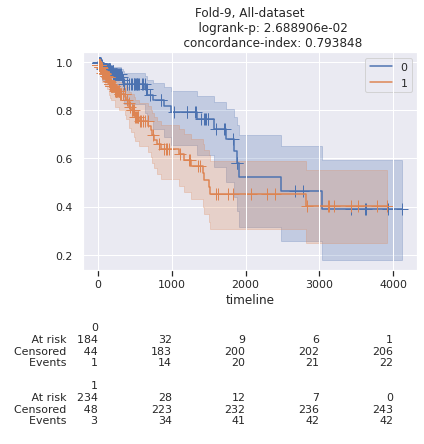

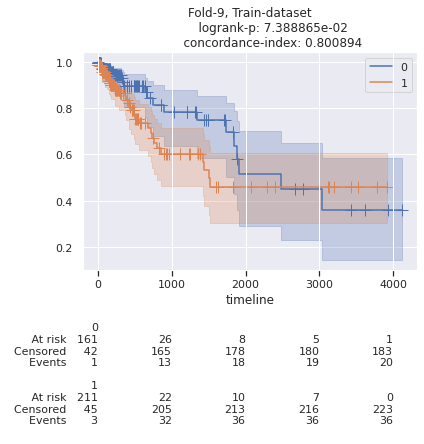

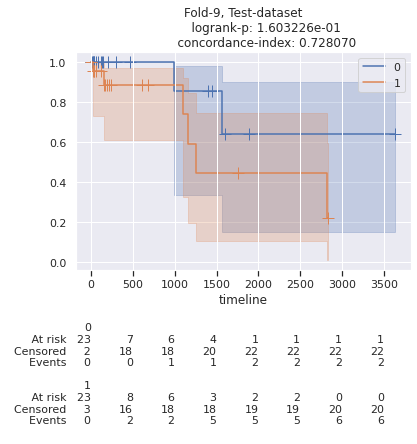

In [21]:
n_splits = 10
fold_results = []
for fold, (train_index, test_index) in enumerate(KFold(n_splits=n_splits, shuffle=True, random_state=0).split(X)):
    model = PCAClustering()
    model.fit(X[train_index], durations[train_index], events[train_index])
    clusters = model.predict(X)
    hazards = model.calculate_hazard(X)

    results = {}
    for name, indexes in zip(["All", "Train", "Test"], [np.concatenate([train_index, test_index]), train_index, test_index]):
        _, p_value = model.logrank_p_score(clusters[indexes], durations[indexes], events[indexes])
        c_index = model.concordance_index(hazards[indexes], durations[indexes], events[indexes])

        plt.figure()#figsize=(15,10))
        ax = plt.gca()
        kmfs, _ = get_kmfs(clusters[indexes], durations[indexes], events[indexes])
        for kmf in kmfs:
            kmf.plot(show_censors=1, ci_show=1, ax=ax)
        lifelines.plotting.add_at_risk_counts(*kmfs, ax=ax)
        plt.title(
            """Fold-{fold}, {name}-dataset
            logrank-p: {p_value:.6e}
            concordance-index: {c_index:.6f}""".format(
                fold=fold,
                name=name,
                p_value=p_value,
                c_index=c_index,
            )
        )
        plt.show()
        results[name,"p_value"] = p_value
        results[name,"c_index"] = c_index
        results[name,"inv_c_index"] = 1-c_index
        results[name,"asy_c_index"] = abs(1-2*c_index)
    
    fold_results.append(results)

In [22]:
def dropna(x):
    x = np.array(x)
    return x[~np.isnan(x)]

def print_result_table(fold_results, metrics,
        EVALUATION_SETS = ["All", "Train", "Test"],
        AGGREGATION_NAMES = ["mean", "std", "median", "iqr"],
        AGGREGATION_FUNCTIONS = [np.mean, np.std, np.median, lambda x: np.quantile(x,0.75)-np.quantile(x,0.25)],
        float_format = "f"):
    AGGREGATION_NAMES = [f.__name__ for f in AGGREGATION_FUNCTIONS] if AGGREGATION_NAMES is None else AGGREGATION_NAMES
    fold_fmt_str = "Fold-{fold}\t{All:" + float_format + "}\t{Train:" + float_format + "}\t{Test:" + float_format + "}"
    agg_fmt_str = "{agg_name}\t{All:" + float_format + "}\t{Train:" + float_format + "}\t{Test:" + float_format + "}"
    for metric in metrics:
        print("{metric}\tAll\tTrain\tTest".format(metric=metric))
        for fold, results in enumerate(fold_results):
            print(
                fold_fmt_str.format(
                    fold = fold,
                    **{t:results[t,metric] for t in EVALUATION_SETS}
                )
            )
        for agg_name, agg_func in zip(AGGREGATION_NAMES, AGGREGATION_FUNCTIONS):
            aggregated_results = {
                t: agg_func(dropna([r[t,metric] for r in fold_results])) for t in EVALUATION_SETS
            }
            print(agg_fmt_str.format(agg_name=agg_name, **aggregated_results))
        print()

In [23]:
print_result_table(fold_results, ["p_value"], float_format=".6e")

p_value	All	Train	Test
Fold-0	4.836932e-02	2.891458e-02	4.373363e-01
Fold-1	3.395364e-01	5.316769e-01	7.326993e-02
Fold-2	1.001163e-01	1.809555e-01	3.549824e-01
Fold-3	1.505425e-02	1.613088e-02	4.384612e-01
Fold-4	2.175358e-02	1.420388e-02	9.704120e-01
Fold-5	1.222017e-02	7.883695e-03	8.306833e-01
Fold-6	7.331874e-02	5.170176e-02	7.475801e-01
Fold-7	4.641535e-02	9.098255e-03	3.279775e-01
Fold-8	1.398301e-01	7.754785e-02	6.136883e-02
Fold-9	2.688906e-02	7.388865e-02	1.603226e-01
mean	8.235032e-02	9.920019e-02	4.402394e-01
std	9.406739e-02	1.525148e-01	3.007380e-01
median	4.739234e-02	4.030817e-02	3.961594e-01
iqr	7.037945e-02	6.194742e-02	4.680640e-01



In [24]:
print_result_table(fold_results, ["c_index", "asy_c_index"], float_format=".3f")

c_index	All	Train	Test
Fold-0	0.796	0.821	0.514
Fold-1	0.758	0.781	0.625
Fold-2	0.728	0.771	0.624
Fold-3	0.817	0.821	0.714
Fold-4	0.766	0.785	0.551
Fold-5	0.790	0.812	0.616
Fold-6	0.733	0.748	0.573
Fold-7	0.662	0.683	0.491
Fold-8	0.777	0.791	0.176
Fold-9	0.794	0.801	0.728
mean	0.762	0.781	0.561
std	0.043	0.039	0.148
median	0.771	0.788	0.594
iqr	0.054	0.036	0.102

asy_c_index	All	Train	Test
Fold-0	0.591	0.642	0.027
Fold-1	0.516	0.563	0.250
Fold-2	0.455	0.542	0.247
Fold-3	0.633	0.642	0.429
Fold-4	0.532	0.569	0.101
Fold-5	0.580	0.624	0.232
Fold-6	0.466	0.496	0.146
Fold-7	0.324	0.367	0.018
Fold-8	0.553	0.582	0.647
Fold-9	0.588	0.602	0.456
mean	0.524	0.563	0.255
std	0.085	0.078	0.192
median	0.542	0.575	0.240
iqr	0.107	0.071	0.272



(0.0, 1.0)

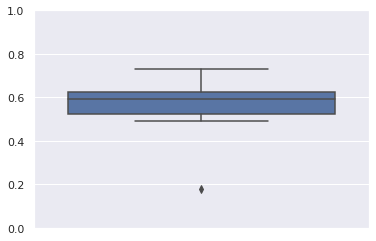

In [25]:
fig, ax = plt.subplots()
sns.boxplot(y=[r["Test","c_index"] for r in fold_results], ax=ax)
ax.set_ylim(0, 1)

(0.0, 1.0)

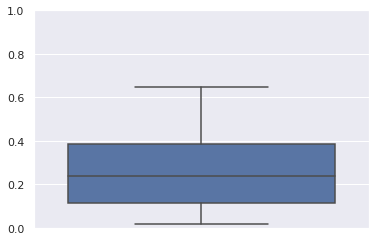

In [26]:
fig, ax = plt.subplots()
sns.boxplot(y=[r["Test","asy_c_index"] for r in fold_results], ax=ax)
ax.set_ylim(0, 1)

(0.0, 1.0)

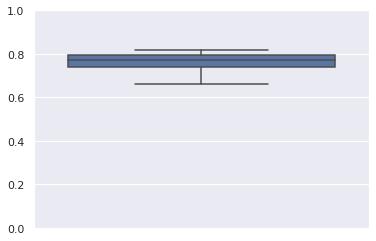

In [27]:
fig, ax = plt.subplots()
sns.boxplot(y=[r["All","c_index"] for r in fold_results], ax=ax)
ax.set_ylim(0, 1)

(0.0, 1.0)

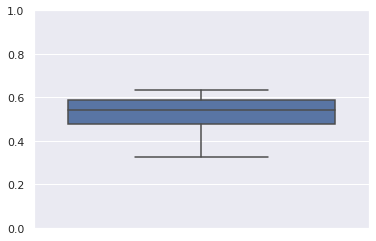

In [28]:
fig, ax = plt.subplots()
sns.boxplot(y=[r["All","asy_c_index"] for r in fold_results], ax=ax)
ax.set_ylim(0, 1)

In [29]:
[r["Test","c_index"] for r in fold_results]

[0.5135135135135135,
 0.625,
 0.6236559139784946,
 0.7142857142857143,
 0.550561797752809,
 0.6159420289855072,
 0.5730337078651685,
 0.49107142857142855,
 0.17647058823529413,
 0.7280701754385965]

In [30]:
[r["All","c_index"] for r in fold_results]

[0.7955078125,
 0.75810546875,
 0.727734375,
 0.8166015625,
 0.7658203125,
 0.79013671875,
 0.73310546875,
 0.662109375,
 0.7765625,
 0.79384765625]

In [31]:
[r["Test","p_value"] for r in fold_results]

[0.4373363370547708,
 0.07326992883415756,
 0.3549824135532642,
 0.4384611907357825,
 0.970411950380935,
 0.8306832599922753,
 0.7475800984949468,
 0.32797749601365384,
 0.061368829139402094,
 0.1603226359757725]

In [32]:
[r["All","p_value"] for r in fold_results]

[0.048369322928687765,
 0.3395363785056002,
 0.10011629361383473,
 0.015054247056230026,
 0.021753581919977394,
 0.012220174083884193,
 0.07331874176407024,
 0.04641534855620727,
 0.139830076620228,
 0.026889063893707453]